## Introduction

In this exercise, classification models will be used to answer what factors lead to employee attrition in the Healthcare industry. The dataset used is a Kaggle dataset which can be found [here.](https://www.kaggle.com/code/emirhanaydn/eda-and-ml-randomforest-predict-93/data)

We will go through data cleaning, investigating distributions, exploratory data analysis, and then finally modeling using several classification models.

### Sections

* [Importing Packages and Loading Data](#importing-packages-and-loading-data)
* [Data Cleaning](#data-cleaning)
    * [Duplicate and Nulls](#duplicate-nulls)
    * [Unique Values](#unique_values)
    * [Converting Numbers to Strings](#converting)
* [Plotting](#plotting)
    * [Boxplot](#boxplots)
    * [Histograms](#histograms)
    * [Countplots](#countplots)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
    * [Logistic](#lr)
    * [Random Forest](#rf)
    * [Extra Trees](#et)
    * [Gradient Boosting](#gbm)
* [Conclusion](#conclusion)

<h2>Importing Packages and Loading Data <a id = "importing-packages-and-loading-data" class="anchor"></a></h2>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.patches as mpatches
sns.set_theme(style="dark")

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,cross_val_score,KFold,StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,ConfusionMatrixDisplay,classification_report,ConfusionMatrixDisplay,accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Finding path of input file
path = os.getcwd() + '/Data/'
# Finding filename
filename = [f for f in os.listdir(path) if '.csv' in f][0]
# Loading the data into dataframe
df = pd.read_csv(path + filename,low_memory=False)
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [2]:
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


<h2>Data Cleaning <a id = "data-cleaning" class="anchor"></a></h2>
In this section we will perform any data cleaning that we might need, such as filling in nulls (or removing the observation), finding columns with only one unique value, converting some columns from number datatype to string datatype.

### Evaluation of Fields

In this section we will investigate fields in this data set, to see if there are any null values, the uniqueness of each field, and to gauge if these will be suitable for our model in the later section


#### * Nulls

As seen below, there are no missing values for any of the fields, thus no need to fill in any missing values

In [3]:
mv = df.isnull().sum().sort_values(ascending=False).to_frame('Missing Values')
mv['% missing'] = round(mv['Missing Values']/df.shape[0]*100)
mv = mv.merge(df.nunique().to_frame('Unique Values'),right_index=True,left_index=True).sort_index()
describe = df.describe().T
mv = mv.merge(describe,how='left',left_index=True,right_index=True)
mv.loc[mv['count'].notnull(),'Type'] = 'number'
mv['Type'].fillna('string',inplace=True)
mv['mean'] = mv['mean'].round(3)

# Fields that are integer and have less than 7 unique values -> Categorical
col_num_to_string = list(mv[(mv['Type']=='number') & (mv['Unique Values']<7)].index)
col_num_to_string.append('EmployeeID')
mv.loc[col_num_to_string,[i for i in describe]] = np.nan
mv.loc[col_num_to_string,'Type'] = 'string'

mv = mv.drop(['count'],axis=1)
mv

,Missing Values,% missing,Unique Values,mean,std,min,25%,50%,75%,max,Type
Age,0,0.0,43,36.866,9.129126,18.0,30.00,36.0,43.00,60.0,number
Attrition,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
BusinessTravel,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
DailyRate,0,0.0,886,800.558,401.594438,102.0,465.00,796.5,1157.00,1499.0,number
Department,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
DistanceFromHome,0,0.0,29,9.222,8.158118,1.0,2.00,7.0,14.00,29.0,number
Education,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EducationField,0,0.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EmployeeCount,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EmployeeID,0,0.0,1676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string


##### Rate Columns
Do we need all the rate columns: Hourly, Daily, Monthly? Will they be correlated with each other? From below, it does not look like they are highly correlated, in fact we see some negative correlation which does not make sense. We will most likely keep all 3.

In [4]:
df[[x for x in df if 'Rate' in x]].corr()

,DailyRate,HourlyRate,MonthlyRate
DailyRate,1.000000,0.027128,-0.032211
HourlyRate,0.027128,1.000000,-0.025597
MonthlyRate,-0.032211,-0.025597,1.000000


#### * Unique Values
There are values where there is only one missing value, lets look at those. Since these fields have only one unique value, this does not add any information to any analysis we might do

In [5]:
cols_drop = []
print ('The following fiels have only 1 unique value:')
for i in mv[mv['Unique Values']==1].index:
    cols_drop.append(i)
    print (' ',i,':',df[i].unique())

The following fiels have only 1 unique value:
  EmployeeCount : [1]
  Over18 : ['Y']
  StandardHours : [80]


In [6]:
print ('The following fiels have only 2 unique value:')
for i in mv[mv['Unique Values']==2].index:
    print (' ',i,':',df[i].unique())

The following fiels have only 2 unique value:
  Attrition : ['No' 'Yes']
  Gender : ['Female' 'Male']
  OverTime : ['Yes' 'No']
  PerformanceRating : [3 4]


For the fields with two unique values, only one does not make sense, which is performance rating, which is either 3 or 4. We might convert his to a field that is "performance rating 4" and it is either 1 (if its 4) or 0 (if its 3). Same goes for other binary variables: Overtime, Attrition (dependent variable), and Gender.

#### * Converting Some Integer Columns to Strings
#### * Turning Dependent Variable into Binary

For the dependent variable, Attrition, we need to turn from True/False to 1 or 0

In [7]:
df1 = df.copy()
# Converting these columns from integer to string
df1[col_num_to_string] = df1[col_num_to_string].applymap(str)
df1 = df1.drop(cols_drop,axis=1)
# Attrition from T/F to 1/0
df1['Attrition'] = df1['Attrition'].apply(lambda x: 1 if x=='Yes' else 0)
# Overtime
df1['OverTime'] = df1['OverTime'].apply(lambda x: 1 if x=='Yes' else 0)

# # Performance Rating
# df1['PerformanceRating_4'] = df1['PerformanceRating'].copy()
# # For Performance Rating, it is only a 3 or 4, we will need to modify this
# df1['PerformanceRating_4'] = df1['PerformanceRating_4'].apply(lambda x: 1 if x=='4' else 0)
# # Gender
# df1['Gender_F'] = df1['Gender'].copy()
# # For Performance Rating, it is only a 3 or 4, we will need to modify this
# df1['Gender_F'] = df1['Gender_F'].apply(lambda x: 1 if x=='Female' else 0)

df1['Attrition'] = df1['Attrition'].astype(str)
df1['OverTime'] = df1['OverTime'].astype(str)
#df1['Gender_F'] = df1['Gender_F'].astype(str)
#df1['PerformanceRating_4'] = df1['PerformanceRating_4'].astype(str)

#df1 = df1.drop(['PerformanceRating','Gender'],axis=1)

In [8]:
# Number columns
df_numbers = df1.select_dtypes(include=np.number)
col_numbers = df_numbers.columns.tolist()

# String Columns
df_string = df1.select_dtypes(exclude=np.number)
df_string = df_string.drop(['EmployeeID'],axis=1)
col_string = df_string.columns.tolist()

<h2>Plotting <a id = "plotting" class="anchor"></a></h2>

#### Distribution of integer/float columns
Below are box plots and histograms of numbered columns

<h4>Boxplots <a id = "boxplots" class="anchor"></a></h4>
Box Plot contains the following:

    1. "Minimum"
    2. First Quartile or 25%
    3. Median (Second Quartile) or 50%
    4. Third Quartile or 75%
    5. "Maximum"
    
Any observations beyond the "minimum" and "maximum" are considered outliers. The following fields/features have outliers:

* MonthlyIncome
* NumCompaniesWorked
* TotalWorkingYears
* TrainingTimesLastYear
* YearsAtCompany
* YearsInCurrentRole
* YearsSinceLastPromotion
* YearsWithCurrManager

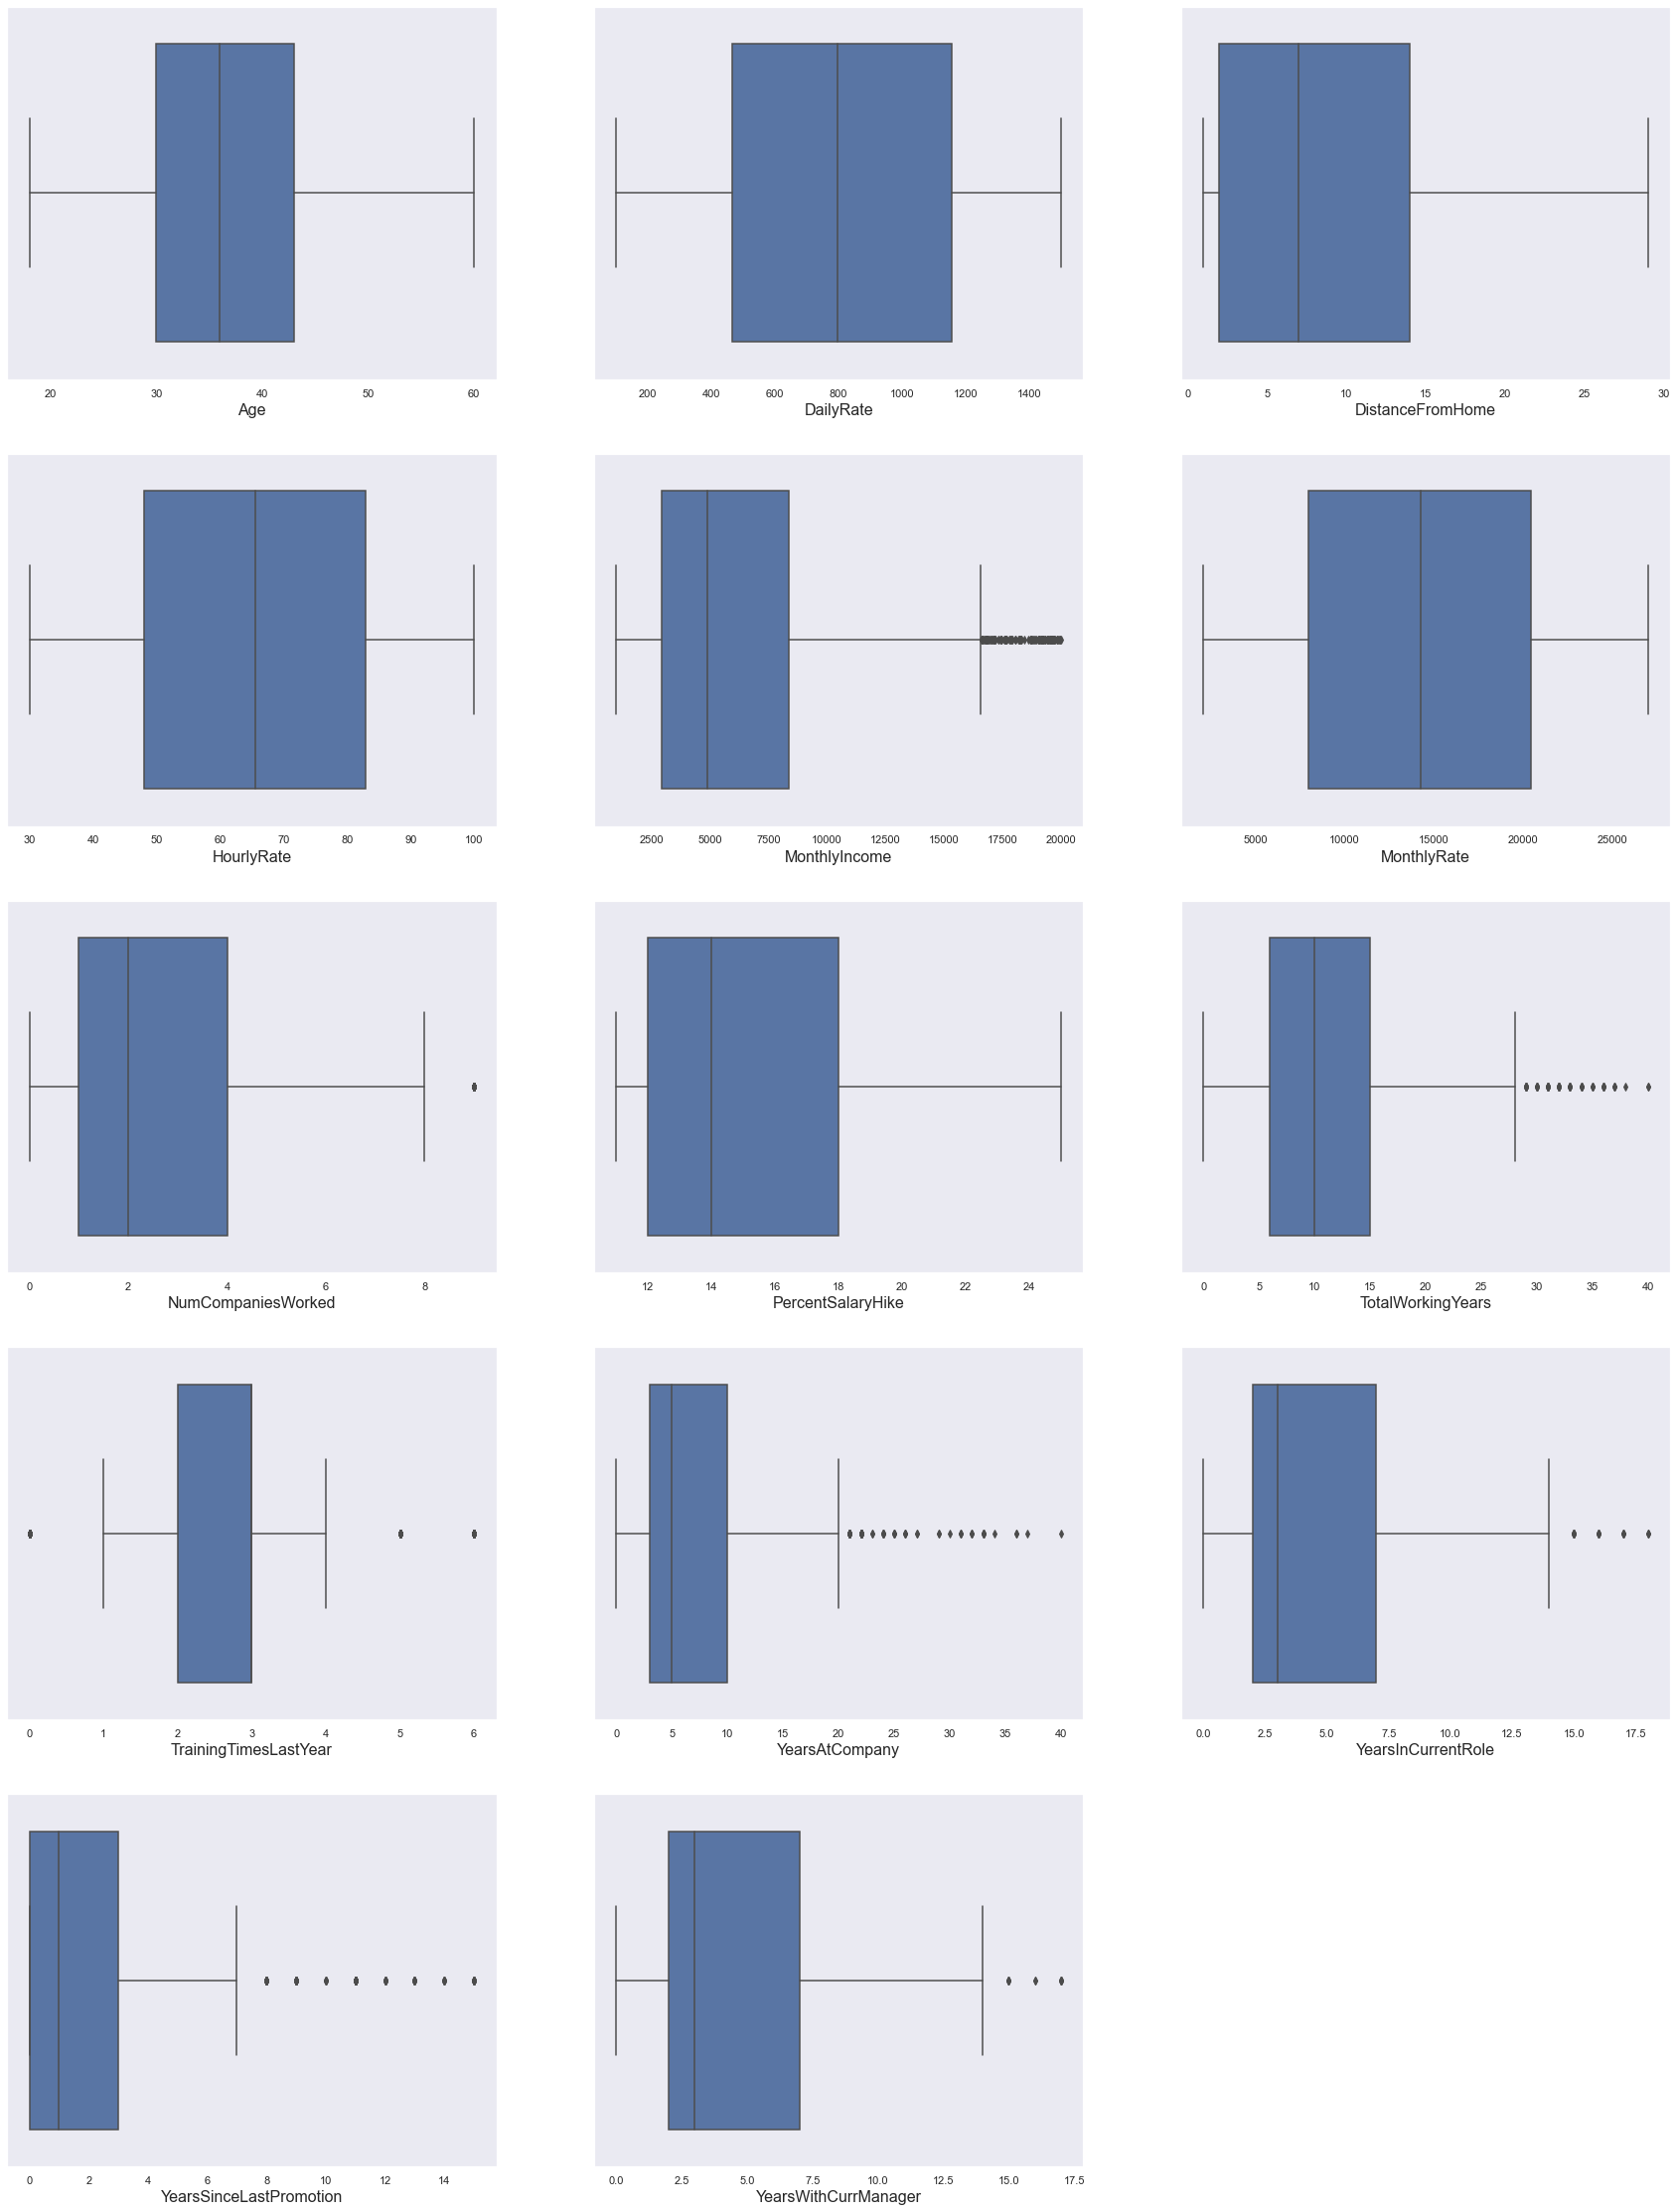

In [9]:
plt.figure(figsize=(30,40))
for i,c in enumerate(df_numbers):
    plt.subplot(5,3,i+1)
    sns.boxplot(data=df_numbers,x=c)
    plt.xlabel(c,fontsize=16)

<h4>Histograms <a id = "histograms" class="anchor"></a></h4>
Shows distribution of each columns (Below)

* Age - shows somewhat close to a normal distribution but still shows left skewness
* DailyRate - not quite of a uniform distribution, but close to it.
* DistanceFromHome - left skewed, most people work close to where they live.
* HourlyRate - much like daily rate, not quite uniform, but close to it
* MonthlyIncome - left skewness
* MonthlyRate - much like daily rate, not quite uniform, but close to it

The following columns show left skewness to their distribution:
* NumCompaniesWorked 
* PercentSalaryHike
* TotalWorkingYears
* YearsAtCompany
* YearsInCurrentRole
* YearsSinceLastPromotion
* YearsWithCurrManager


We might need to transform some of the fields using scaling options to that they are in normal distribution, lets look to see if it is needed

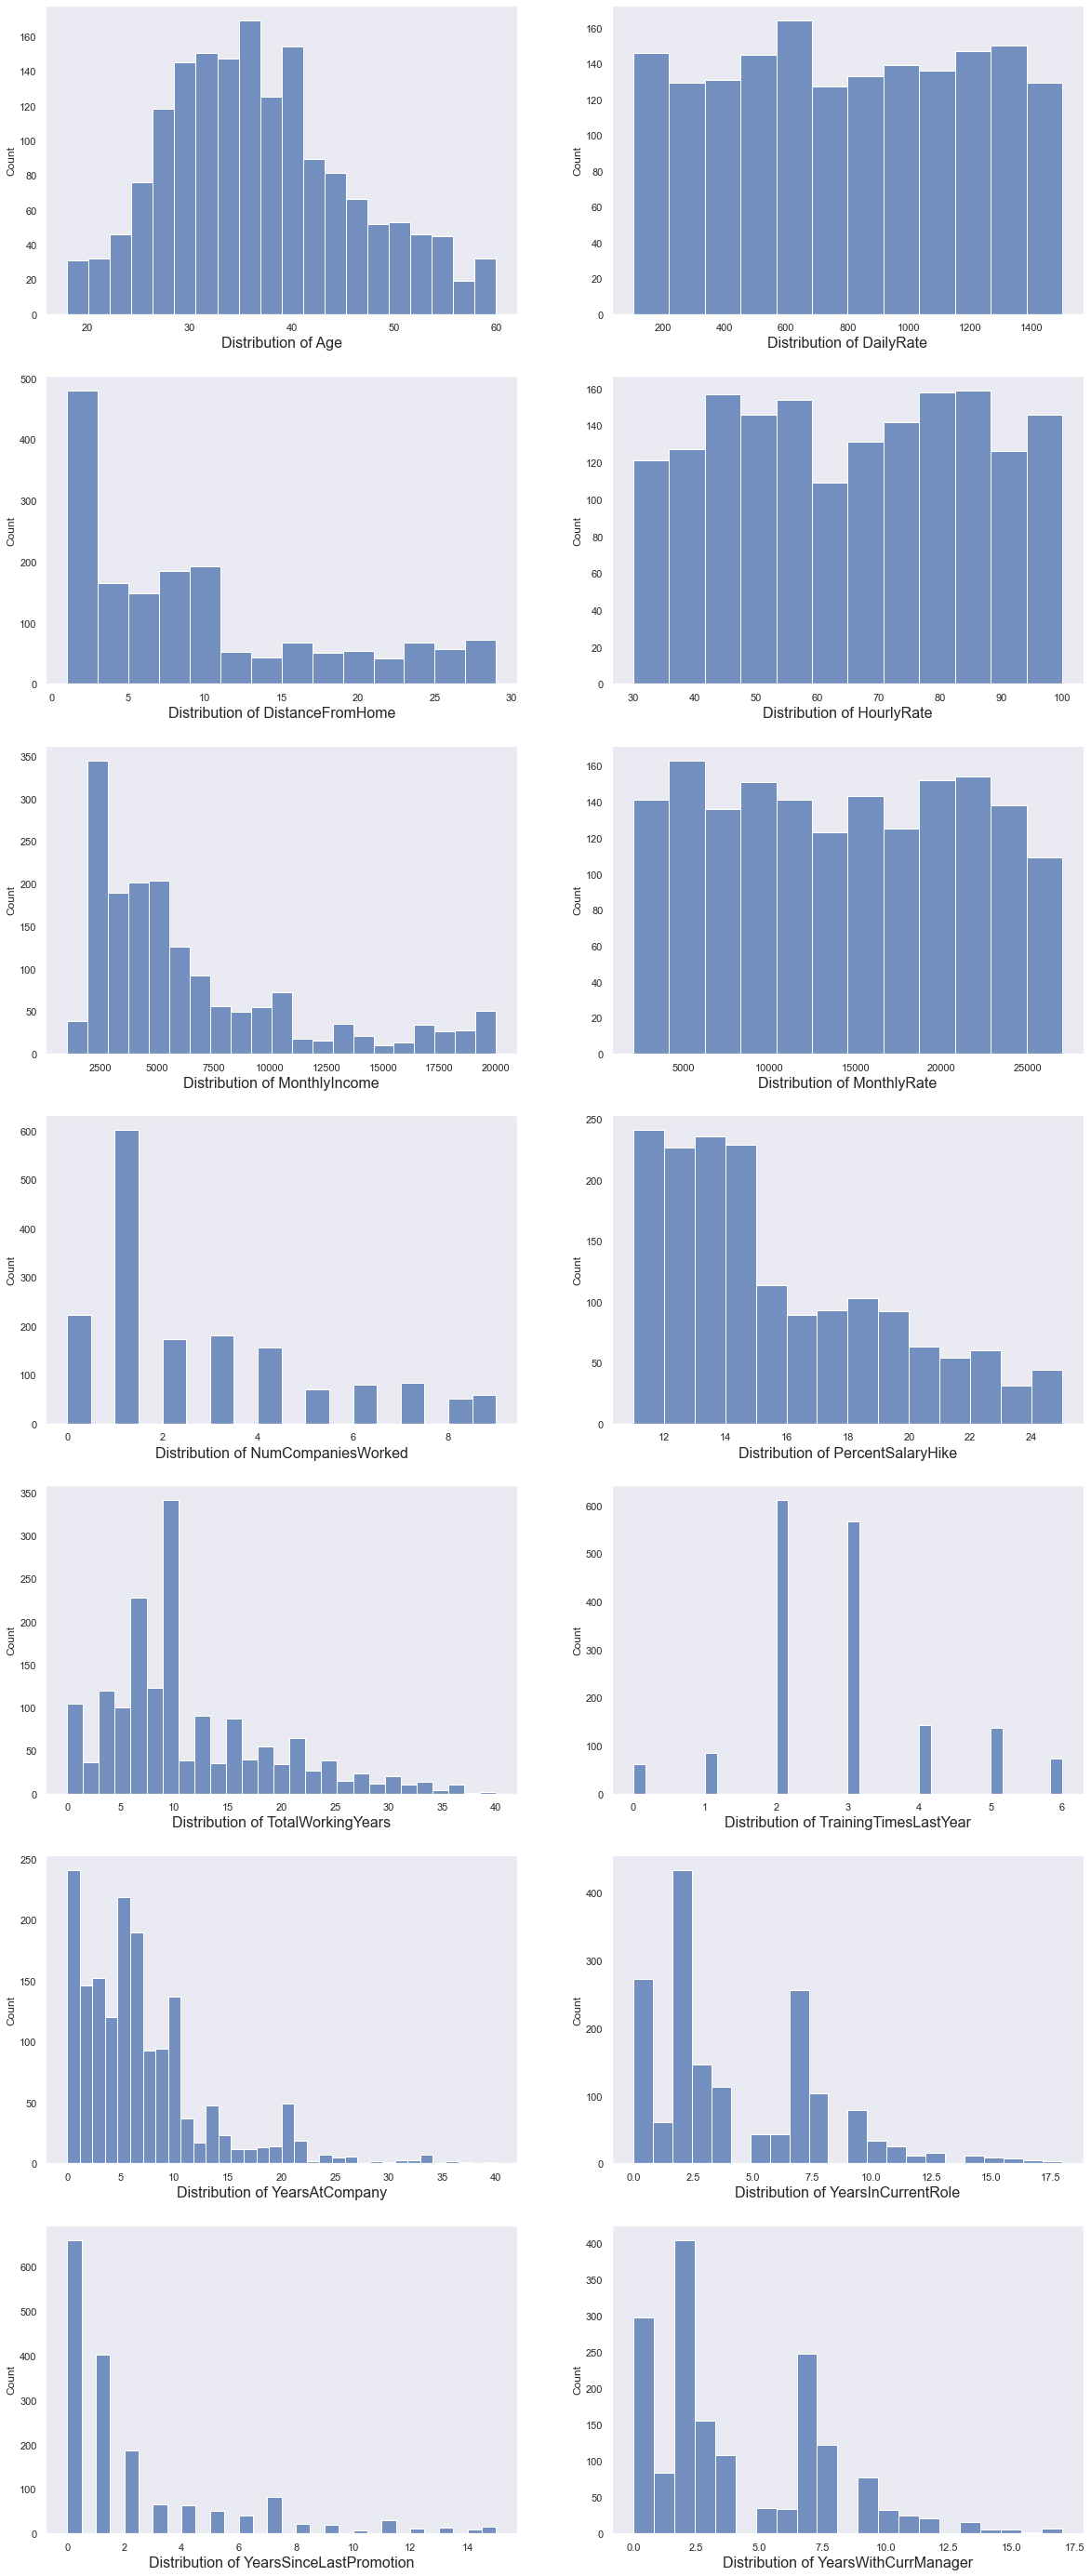

In [10]:
# def plot_histogram(data,col,bin_size): 
#     plt.figure(figsize=(12,8))
#     data[col].hist(bins=bin_size)
#     plt.xlabel(col,fontsize=16)
#     plt.title('Distribution of {}'.format(col),fontsize=18);
#     return

# Plotting Histograms
#[plot_histogram(df,c,20) for c in list(col_numbers)];
    
plt.figure(figsize=(20,50))    
for i,c in enumerate(df_numbers):
    plt.subplot(7,2,i+1)
    sns.histplot(x=c,data=df_numbers)
    plt.xlabel('Distribution of {}'.format(c),fontsize=16)

### Plots of Categorical Variables
<h4>Countplots <a id = "countplots" class="anchor"></a></h4>

Here we will plot categorical fields with respect to attrition by plotting the count of observations

Count of Each Categorical Variable


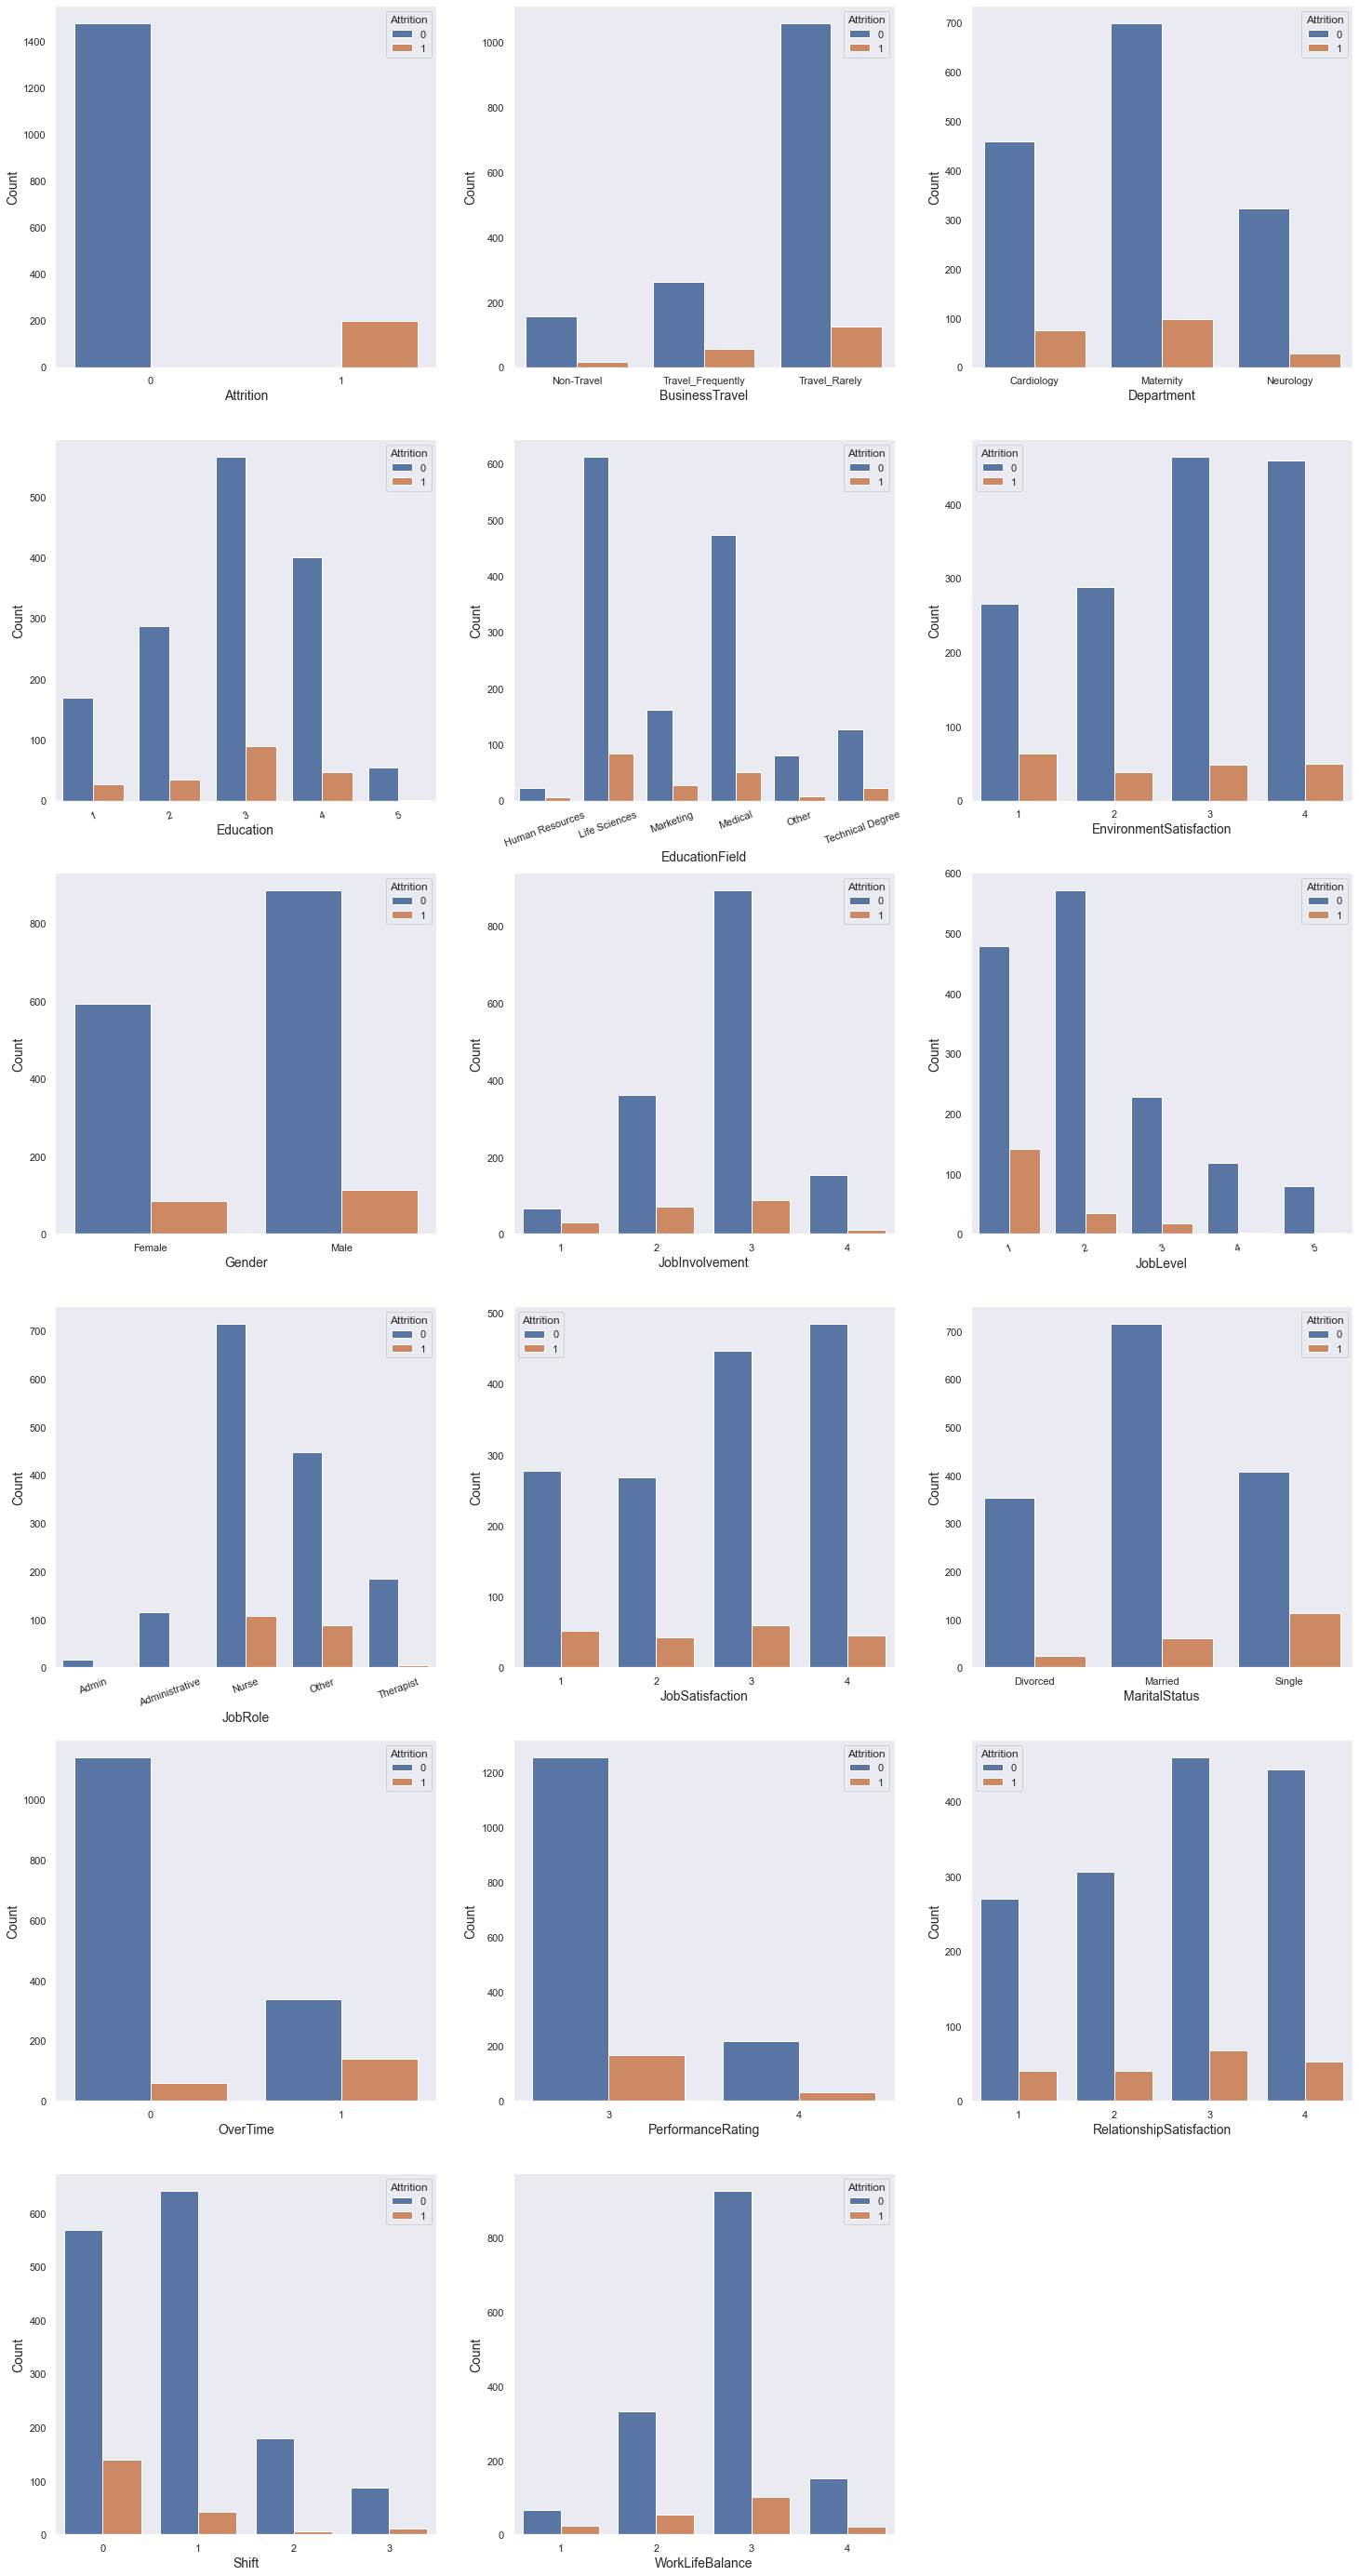

In [11]:
plt.figure(figsize=(25,50))
print ('Count of Each Categorical Variable')
for i,c in enumerate(df_string):
    plt.subplot(6,3,i+1)
    ax = sns.countplot(data=df_string,hue='Attrition',x=c,order=sorted(df_string[c].unique()))
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Count',fontsize=14)
    if df_string[c].nunique()>4:
        plt.xticks(rotation=20)
    else:
        pass

<h2>Exploratory Data Analysis <a id = "eda" class="anchor"></a></h2>
Some of the questions we will tackle are:

1) How do columns (features, independent variables) interact with the dependent variable, attrition?
2) Are there correlation among features?

#### Heatmap

Below plot shows the heatmap of the correlation between variables. The following features are positively correlated with each other:

* Age, 
* MonthlyIncome, 
* TotalWorkingYears
* YearsAtCompany
* YearsInCurrentRole
* YearsSinceLastPromotion
* YearsWithCurrManager

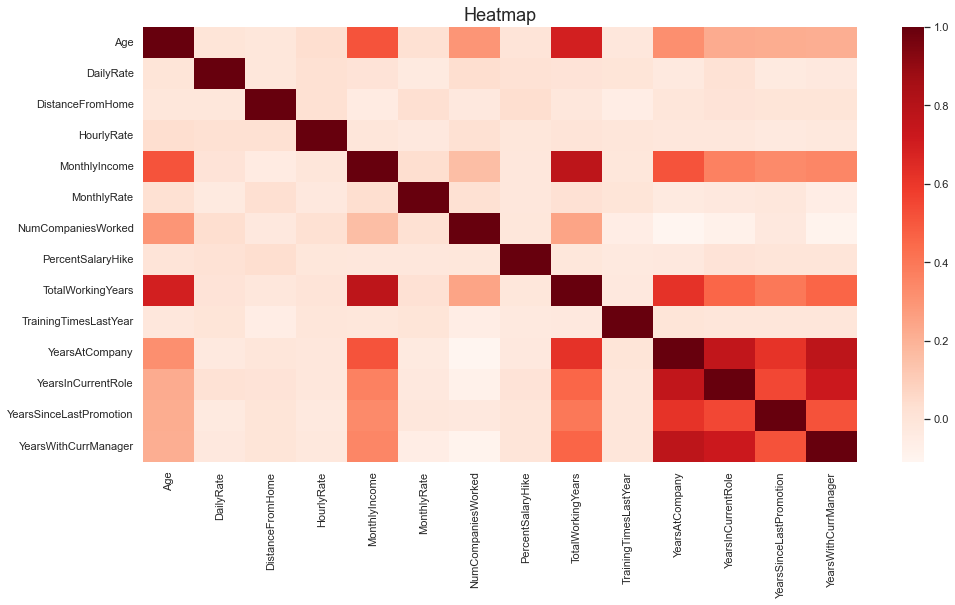

In [12]:
corr = df1.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap='Reds')
plt.title('Heatmap',fontsize=18);

#### PairPlots

* Monthly Income vs Age for Attrition
    * The coeffecient for regression for Attrition is lower than the one for No Attrition, which makes sense, as money is often a criteria for leaving. 
* Monthly Income vs Age for JobRole
    * Each of the JobRoles have a positive coefficient for MonthlyIncome as a person ages, except for 'Admin' where we see a negative correlation with age, where the age starts in late 30s.
* ?

<Figure size 1440x720 with 0 Axes>

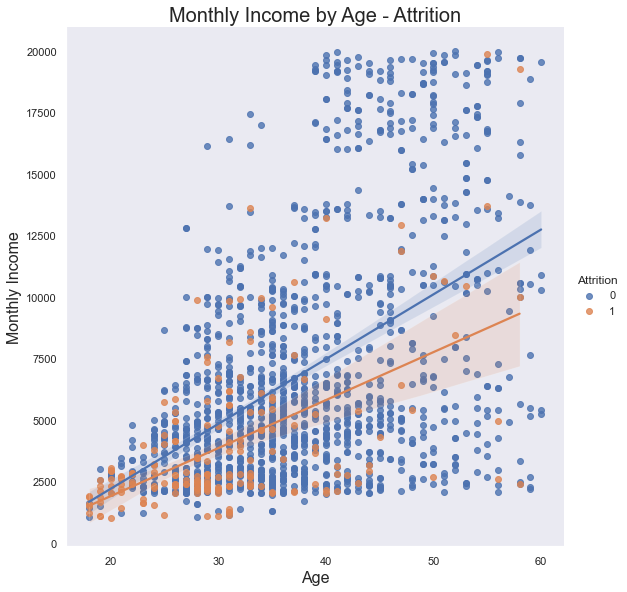

In [13]:
plt.figure(figsize=(20,10))
sns.pairplot(x_vars='Age',y_vars='MonthlyIncome',data=df1,size=8,hue='Attrition',kind="reg")
plt.title('Monthly Income by Age - Attrition',fontsize=20)
plt.xlabel('Age',fontsize=16)
plt.ylabel('Monthly Income',fontsize=16)
plt.show();

<Figure size 1440x720 with 0 Axes>

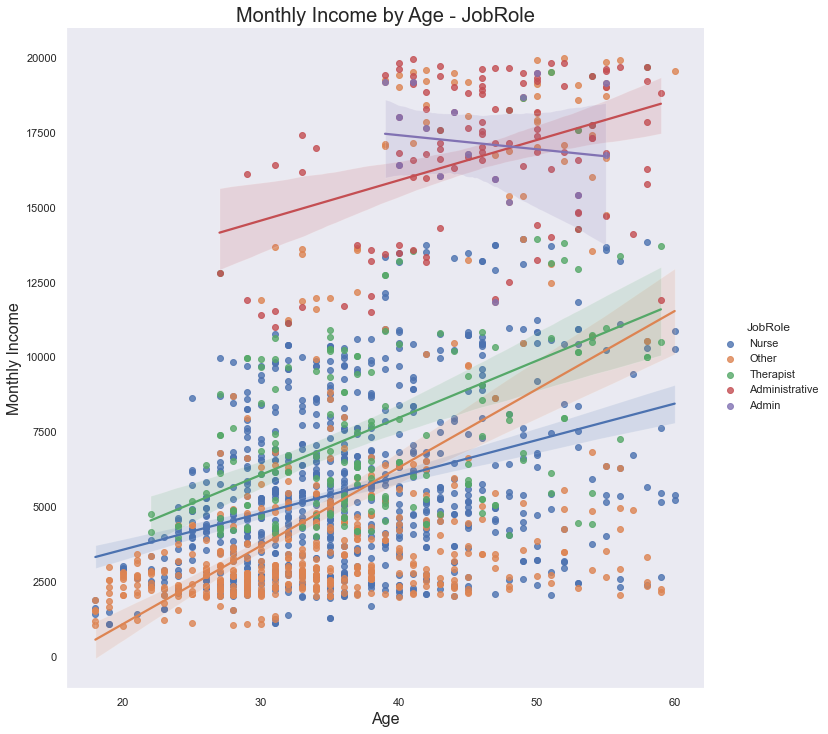

In [14]:
plt.figure(figsize=(20,10))
sns.pairplot(x_vars='Age',y_vars='MonthlyIncome',data=df1,size=10,hue='JobRole',kind="reg")
plt.title('Monthly Income by Age - JobRole',fontsize=20)
plt.xlabel('Age',fontsize=16)
plt.ylabel('Monthly Income',fontsize=16)
plt.show();

In [15]:
# There is a class imbalance
print ('Percentage of employees that left the workplace is {}%'.format((100*(df1['Attrition'].value_counts()[1]/df1['Attrition'].value_counts().sum())).round(2)))

Percentage of employees that left the workplace is 11.87%


#### Plotting Categorical Variable Against Attrition

In [16]:
# def interaction(col1,col2):
#     '''
#     Creating a Pivot Table based on col1 and col2 (Attrition), and then graphing the values using a stacked bar chart
#     col1: dependent variable/field/feature
#     col2: it is generic, but when calling the function, it will be Attrition
#     returns:
#         pivot table, graph
#     '''
#     pt = df.groupby([col1,col2])['EmployeeID'].count().unstack()
#     pt['No%'] = round(100*(pt['No']/pt.sum(axis=1)),2)
#     pt['Yes%'] = round(100*(pt['Yes']/pt.sum(axis=1)),2)
#     # set the figure size
#     plt.figure(figsize=(10, 10))
#     # Barcharts for No% and Yes%
#     bar1 = sns.barplot(x=pt.index, y="No%", data=pt, color='darkblue')
#     bar2 = sns.barplot(x=pt.index, y="Yes%", data=pt, color='lightblue')
#     # add legend
#     top_bar = mpatches.Patch(color='darkblue', label='No Attrition')
#     bottom_bar = mpatches.Patch(color='lightblue', label='Attrition')
#     # changing xticks
#     plt.yticks(np.arange(0,101,5))
#     plt.legend(handles=[top_bar, bottom_bar])
#     plt.title('{} by {}'.format(col1,col2),fontsize=18)
#     plt.ylabel('Percentage',fontsize=14)
#     plt.xlabel(col1,fontsize=14)
#     # show the graph
#     plt.show()
    
#     return pt.reset_index()

# pt0 = interaction(col_string[14],col_string[0])
# pt0

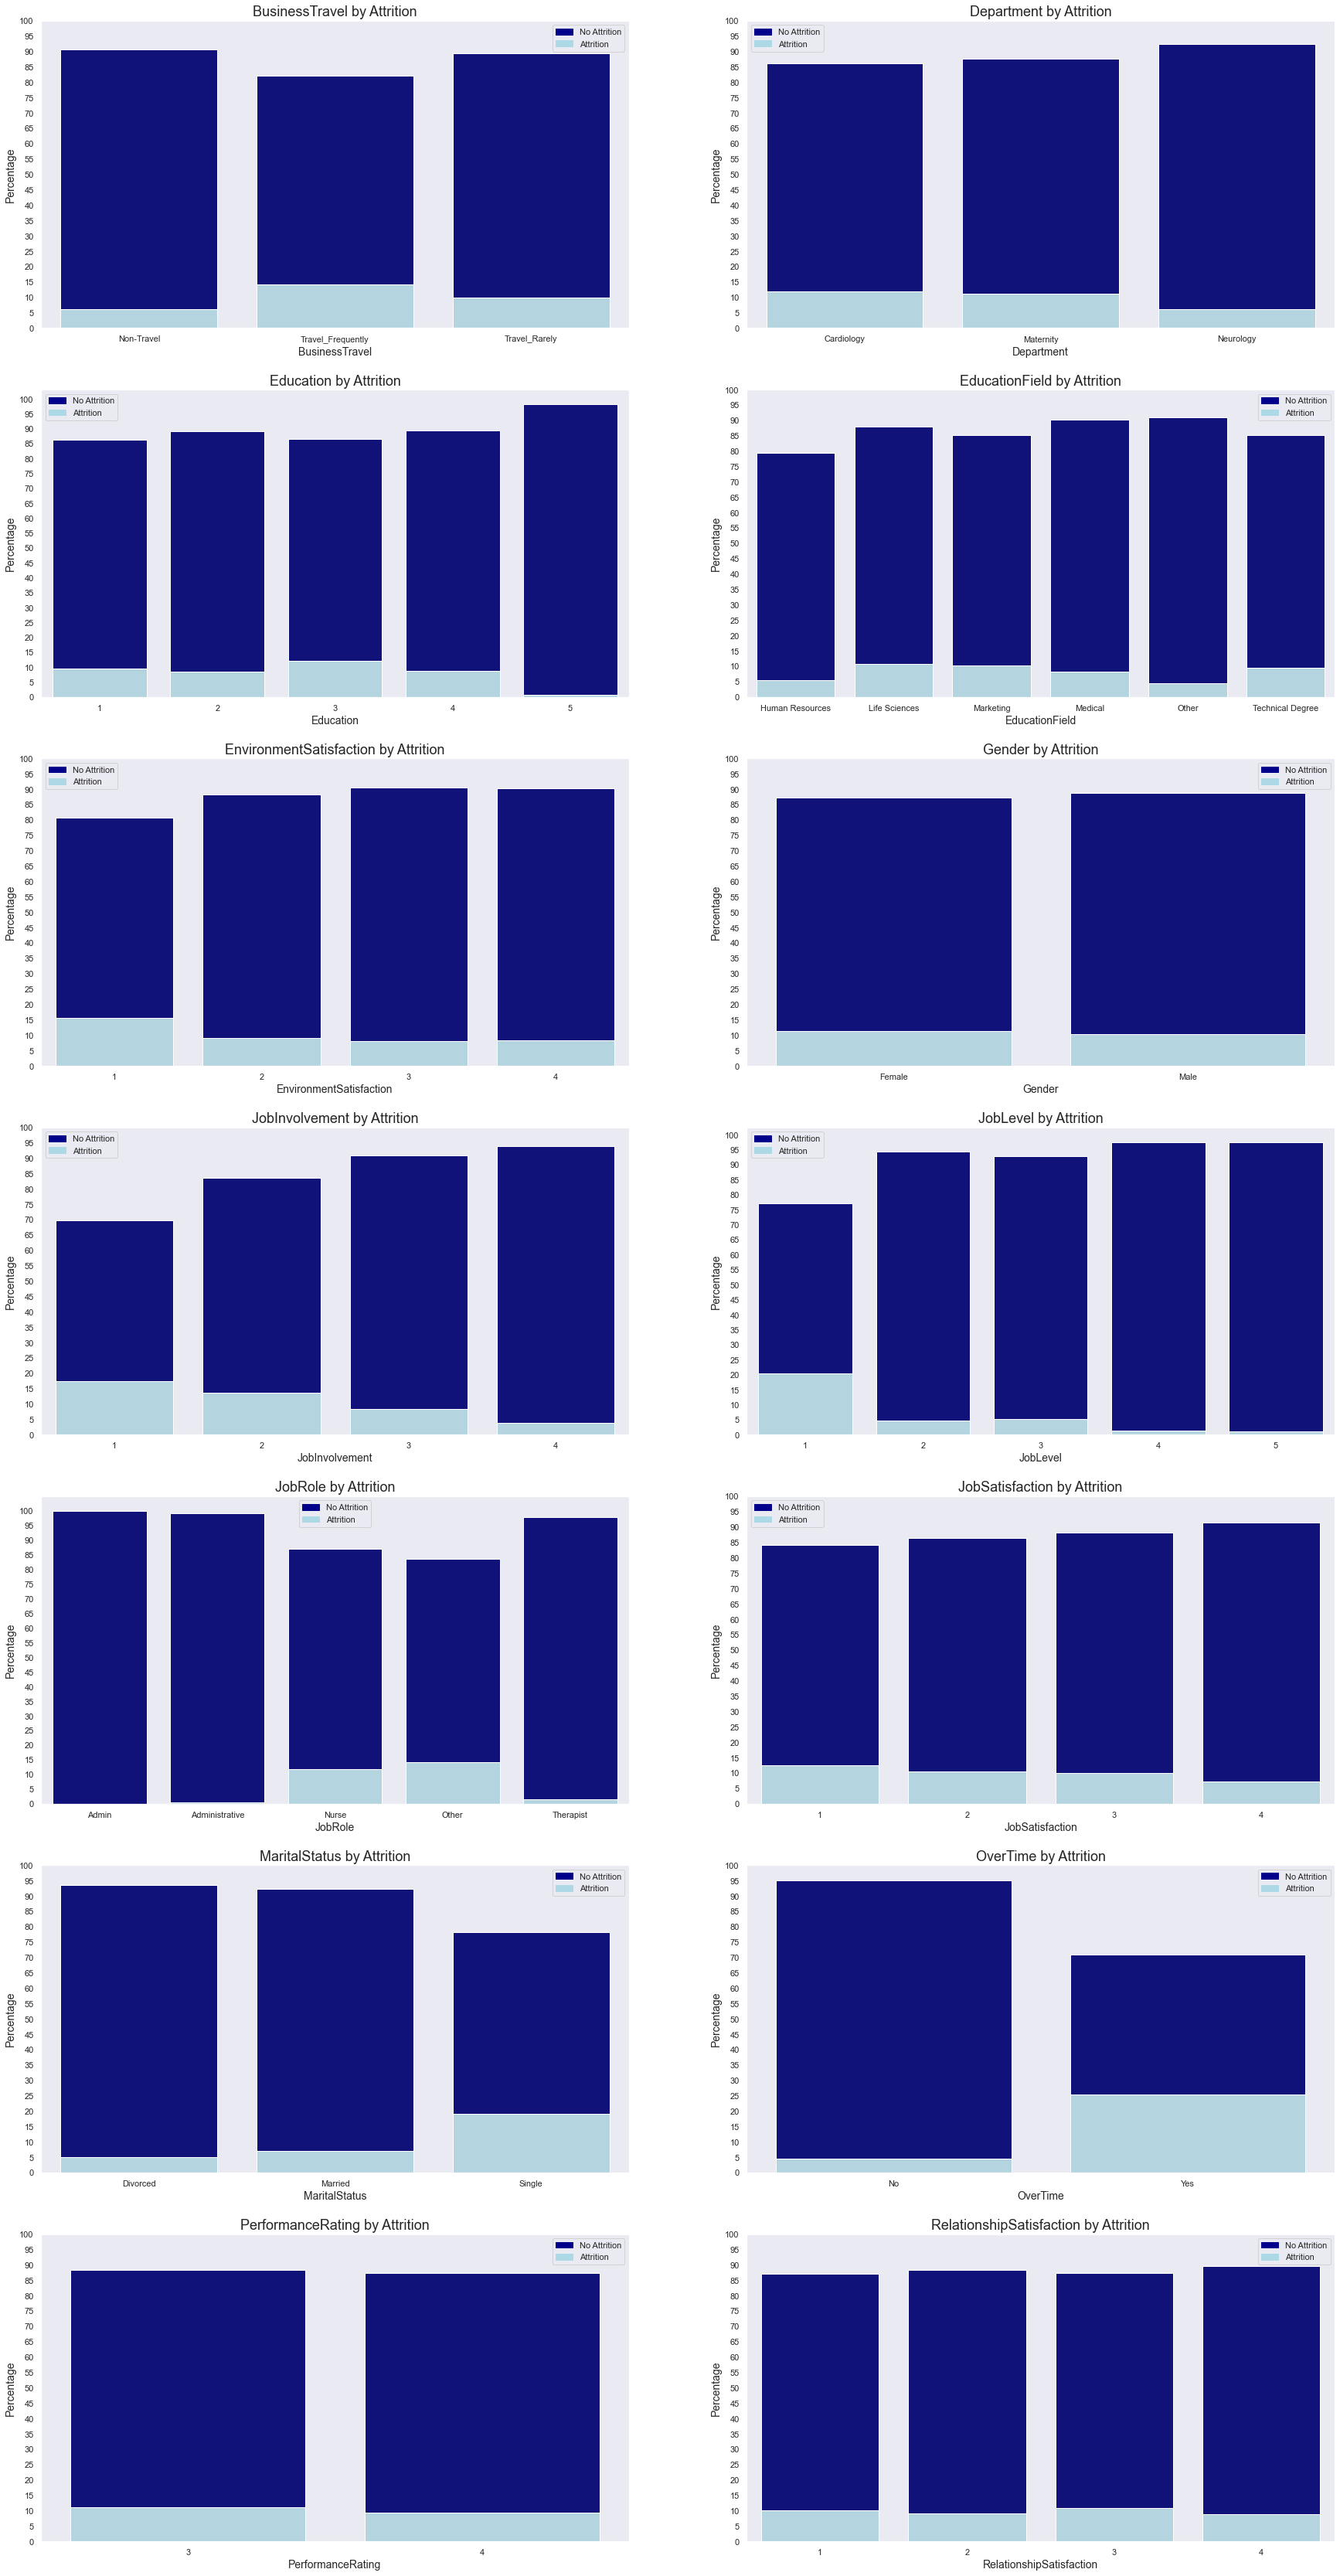

In [17]:
plt.figure(figsize=(30, 60))
for i,c in enumerate(df_string.columns.values.tolist()[1:15]):
    plt.subplot(7,2,i+1)
    pt = df.groupby([c,'Attrition'])['EmployeeID'].count().unstack()
    pt['No%'] = round(100*(pt['No']/pt.sum(axis=1)),2)
    pt['Yes%'] = round(100*(pt['Yes']/pt.sum(axis=1)),2)
    pt = pt.reset_index()
    # # Barcharts for No% and Yes%
    bar1 = sns.barplot(x=c, y="No%", data=pt, color='darkblue')
    bar2 = sns.barplot(x=c, y="Yes%", data=pt, color='lightblue')
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label='No Attrition')
    bottom_bar = mpatches.Patch(color='lightblue', label='Attrition')
    # changing xticks
    plt.yticks(np.arange(0,101,5))
    plt.legend(handles=[top_bar, bottom_bar])
    plt.title('{} by {}'.format(c,'Attrition'),fontsize=18)
    plt.ylabel('Percentage',fontsize=14)
    plt.xlabel(c,fontsize=14)

<h2>Modeling <a id = "modeling" class="anchor"></a></h2>
We will cover the following models and see how they stack up

* Logistic Regression
* Random Forest
* Extra Trees
* Gradient Boosting
* XGBoost

first thing first, we will need to convert some features to dummy variables, we will do this by using the pandas function getdummies

#### Creating dataframe of dummy variables
Used [this](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) as an example for dummy variables and RFE.


In [18]:
# This is the dependent variables
y = df1['Attrition']
# Creating a dataframe dropping EmployeeID and Attrition (dependent variable)
data = df1.drop(['EmployeeID','Attrition'],axis=1)
df2 = data.copy()
# Grabbing the string columns to convert to dummy variables
cat_vars=[x for x in col_string if (x in data)]
# creating dummy for each variable and then joinin with copied df
for var in cat_vars:
    cat_list='var'+'_'+var
    #print (cat_list)
    cat_list = pd.get_dummies(data[var], prefix=var)
    data=data.join(cat_list)
# Total features
data_vars = data.columns.values.tolist()
# Columns that will be kept
cols_keep = [i for i in data_vars if i not in cat_vars]
# final data
data_final=data[cols_keep]
#data_final.columns.values

#### Pipelines/Transforming Columns
Here we will construct pipeline for numeric and categorical so that we can transform them using standardscalar and one hot encoding, respectively, so that they will be used for modeling. Tutorial i used was located [here.](https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)

In [19]:
col_string1 = [x for x in col_string if x!='Attrition']
rs = 25

import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Pipeline for Categorical Features
categorical_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="most_frequent")),
           ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False))])

# Pipeline for Numerical Features
from sklearn.preprocessing import StandardScaler
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())])

# Combining Categorical and Numerical Pipeline
from sklearn.compose import ColumnTransformer
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, col_numbers),
        ("categorical", categorical_pipeline, col_string1)])
numeric_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, col_numbers)])
# Converting target variable from string to numerical
y1 = y.astype(int)

# Apply preprocessing to df2
X_processed = full_processor.fit_transform(df2)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(y1.values.reshape(-1, 1))

#df_numbers1 = pd.DataFrame(numeric_processor.fit_transform(df_numbers),columns=col_numbers)



# # XGBOOST
# xgb_cl = xgb.XGBClassifier()
# # Init classifier
# xgb_cl = xgb.XGBClassifier()

# # Fit
# xgb_cl.fit(X_train1, y_train1)

# # Predict
# preds = xgb_cl.predict(X_test1)

# # Score
# accuracy_score(y_test1, preds)



In [20]:
df2.shape,data_final.shape

((1676, 30), (1676, 74))

In [21]:
# xgboost = Pipeline(steps=[('preprocessor', full_processor),
#                       ('classifier', xgb_cl)])

# xgboost.named_steps['preprocessor'].transformers_[1][1]\
#    .named_steps['oh-encode'].get_feature_names(col_string1).tolist()

#### Creating Training and Test Data

In [22]:
# Creating Train/Test split
X_train, X_test, y_train, y_test = train_test_split(data_final, y, test_size=0.3, random_state=rs)
# features
data_final_vars=data_final.columns.values.tolist()

# X_cols=[i for i in data_final_vars if i not in y]
# X_train = X_train[X_cols]
print (X_train.shape)

# Processed Data
# Train/Test Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=rs,test_size=0.3)
print (X_train1.shape)

(1173, 74)
(1173, 74)


#### Terminology

* Recursive Feature Elimination (RFE)
    * A feature selection algorithm. It is used to select columns/features/dependent variables in a dataset that more/most important in predicting the dependent variable, in this case, attrition.
* Cross Validation
    * Cross Validation is a statistical tool to estimate the performance of models.
* GridsearchCV
    * GridsearchCV is used for hyperparameter tuning to select the best parameters for the model
* AUC
    * ?

In [23]:
def skf_cross_val_score(model,ind_vars_df,dep_vars):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)
    m_cvs = cross_val_score(model,ind_vars_df,dep_vars,cv=skf,n_jobs=-1)
    print("Average Cross Validation score :{}".format(m_cvs.mean()))
    return m_cvs

def false_negative_pct(ytest,ypred):
    '''
    Calculating False Negatives/False Positives for Classifiers
        ytest: Actual dependent variable
        ypred: Prediction of dependent variable after running the prediction method for a given model
    returns:
        dataframe of actual and predicted y values and creates a flag for TP,TN,FP,FN
    '''
    j = pd.DataFrame([ytest.values,ypred],index=['Actual','Predicted']).T
    j = j.astype(str)
    j.loc[(j['Actual']=='0') & (j['Predicted']=='0'),'Type'] = 'TN'
    j.loc[(j['Actual']=='1') & (j['Predicted']=='1'),'Type'] = 'TP'
    j.loc[(j['Actual']=='0') & (j['Predicted']=='1'),'Type'] = 'FP'
    j.loc[(j['Actual']=='1') & (j['Predicted']=='0'),'Type'] = 'FN'
    fn_pct = round(j[j['Type']=='FN'].shape[0]/j.shape[0],4)
    fp_pct = round(j[j['Type']=='FP'].shape[0]/j.shape[0],4)    
    print ('False Negative:',fn_pct)
    print ('False Positive:',fp_pct)
    return fn_pct,fp_pct

def plot_confusion_matrix(cm,labels,ytest,ypred):
    color = 'black'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix',fontsize=20)
    plt.xlabel('Predicted Label', color=color,fontsize=16)
    plt.ylabel('True Label', color=color,fontsize=16)
    plt.show();
    print(classification_report(ytest, ypred))
    return


# """ Plot AUC"""

# FPR = dict()
# TPR = dict()
# ROC_AUC = dict()

# # For class 1, find the area under the curve
# FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
# ROC_AUC[1] = auc(FPR[1], TPR[1])

# # Plot of a ROC curve for class 1 (has_cancer)
# plt.figure(figsize=[11,9])
# plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
# plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=18)
# plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('Receiver operating characteristic for high/low income', fontsize=18)
# plt.legend(loc="lower right")
# plt.show()

def plot_auc(ytest,yscore):
    """ Plot AUC"""

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(ytest, yscore)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for Attrition', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    return

def _gridsearch(model,xtrain,ytrain,folds):
    C_vals = np.linspace(.33,.66,50)
    penalties = ['l1','l2']

    gs = GridSearchCV(model, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=folds)
    gs1 = GridSearchCV(model, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=folds)
    gs.fit(xtrain, ytrain)
    return gs

dfm = pd.DataFrame(columns=['Accuracy','AUC','False Negative'])

<h3>Logistic Regression <a id = "lr" class="anchor"></a></h3>

Logistic Regression is a statistical method to predict a binary outcome by analyzing relationship of features. There is model for using:

* Scaling option 
* Non-Scaling option
* Non-scaling option with RFE

##### Logistic Regression - Gridsearch

In [24]:
logreg = LogisticRegression(solver='liblinear',random_state=rs)
#C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, .4, .45, 0.5,.55, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
C_vals = np.linspace(.33,.66,50)
penalties = ['l1','l2']

# gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=3)
# gs1 = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=3)
# gs.fit(X_train, y_train)
# gs1.fit(X_train1,y_train1)

# print (gs.best_params_,gs1.best_params_)
#logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
#logreg = LogisticRegression(C=.55, penalty=gs.best_params_['penalty'])
# cv_model = logreg.fit(X_train, y_train)
# cv_pred = cv_model.predict(X_test)

gs = _gridsearch(logreg,X_train1,y_train1,5)
gs.best_params_

{'C': 0.5522448979591836, 'penalty': 'l1'}

##### Logistic Regression using Scaled/Encoded Data

Logistic Regression Accuracy Score: 0.934
AUC Score is: 0.9718397291196388


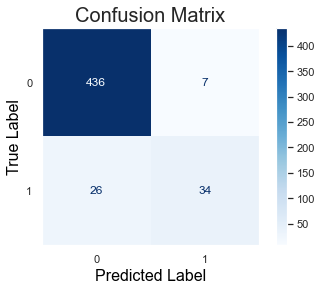

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       443
           1       0.83      0.57      0.67        60

    accuracy                           0.93       503
   macro avg       0.89      0.78      0.82       503
weighted avg       0.93      0.93      0.93       503

False Negative: 0.0517
False Positive: 0.0139


In [25]:
# Calling LogisticRegression
lr = LogisticRegression(random_state=rs,solver='liblinear',n_jobs=-1)
# Gridsearch to find best paramaters
gs = _gridsearch(lr,X_train1,y_train1,5)
# Calling LogisticRegression with Gridsearch
lr = LogisticRegression(random_state=rs,solver='liblinear',C=gs.best_params_['C'],penalty=gs.best_params_['penalty'],n_jobs=-1)
# Fitting Training Data
lr.fit(X_train1,y_train1)
# Predicting using Test set
y_pred = lr.predict(X_test1)
# Accuracy Score
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test1,y_pred).round(3))
# AUC Score
lr_y_score = lr.decision_function(X_test1)
print ("AUC Score is:",roc_auc_score(y_test1, lr_y_score))
# Confusion Matrix
lr_cm = confusion_matrix(y_test1,y_pred)

plot_confusion_matrix(lr_cm,lr.classes_,y_test1,y_pred)
lr_fn_pct,lr_fp_pct = false_negative_pct(pd.DataFrame(y_test1)[0],y_pred)
dfm.loc['Logistic Regression - Scaled Data'] =[accuracy_score(y_test1,y_pred).round(3),roc_auc_score(y_test1, lr_y_score),lr_fn_pct]

In [26]:
# Coefficients of Features
lrc = pd.DataFrame([data_final_vars,lr.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc.head(10)

,Feature,Coefficients
31,EnvironmentSatisfaction_1,1.422063
17,Department_Cardiology,1.018917
37,JobInvolvement_1,0.932478
70,WorkLifeBalance_1,0.833217
66,Shift_0,0.805644
15,BusinessTravel_Travel_Frequently,0.753926
2,DistanceFromHome,0.59743
62,RelationshipSatisfaction_1,0.533281
6,NumCompaniesWorked,0.508934
57,MaritalStatus_Single,0.502768


##### Logistic Regression using Non-Scaled Data

Logistic Regression Accuracy Score: 0.922
AUC Score is: 0.9451345387243736


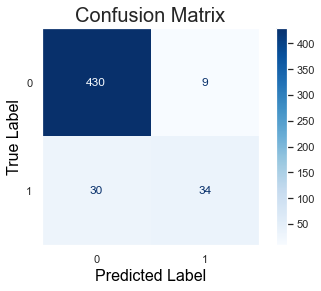

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       439
           1       0.79      0.53      0.64        64

    accuracy                           0.92       503
   macro avg       0.86      0.76      0.80       503
weighted avg       0.92      0.92      0.92       503

False Negative: 0.0596
False Positive: 0.0179


In [27]:
# Calling LogisticRegression
lr = LogisticRegression(random_state=rs)
# Gridsearch to find best paramaters
gs = _gridsearch(lr,X_train,y_train,5)
# Calling LogisticRegression with Gridsearch
lr = LogisticRegression(random_state=rs,solver='liblinear',C=gs.best_params_['C'],penalty=gs.best_params_['penalty'])
# Fitting Training Data
lr.fit(X_train,y_train)
# Predicting using Test set
y_pred = lr.predict(X_test)
# Accuracy Score
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test,y_pred).round(3))
# AUC Score
lr_y_score = lr.decision_function(X_test)
print ("AUC Score is:",roc_auc_score(y_test, lr_y_score))
# Confusion Matrix
lr_cm = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(lr_cm,lr.classes_,y_test,y_pred)
lr_fn_pct,lr_fp_pct = false_negative_pct(y_test,y_pred)
dfm.loc['Logistic Regression - NonScaled Data'] =[accuracy_score(y_test,y_pred).round(3),roc_auc_score(y_test, lr_y_score),lr_fn_pct]


In [28]:
# Coefficients of Features
lrc = pd.DataFrame([X_train.columns.values.tolist(),lr.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc.head(10)

,Feature,Coefficients
59,OverTime_1,1.830017
41,JobLevel_1,0.936867
37,JobInvolvement_1,0.877888
31,EnvironmentSatisfaction_1,0.875019
70,WorkLifeBalance_1,0.868888
66,Shift_0,0.8104
51,JobSatisfaction_1,0.750886
15,BusinessTravel_Travel_Frequently,0.703239
57,MaritalStatus_Single,0.64686
17,Department_Cardiology,0.564163


##### Logistic Regression w RFE andn non-Scaled Data

Logistic Regression Accuracy Score: 0.903
AUC Score is: 0.9086524772209568


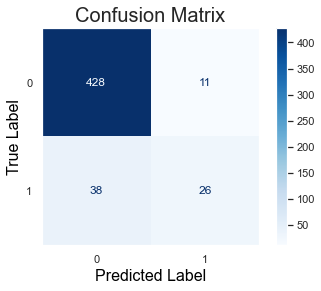

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       439
           1       0.70      0.41      0.51        64

    accuracy                           0.90       503
   macro avg       0.81      0.69      0.73       503
weighted avg       0.89      0.90      0.89       503

False Negative: 0.0755
False Positive: 0.0219


In [29]:
# With RFE
lr1 = LogisticRegression(random_state=rs)
# passing the lr through RFE
lr_rfe = RFE(lr1)
# Fitting the model
lr_rfe = lr_rfe.fit(X_train, pd.DataFrame(y_train).values.ravel())
rfe_results = pd.DataFrame([data_final_vars,lr_rfe.support_,lr_rfe.ranking_],index=['Column','Support','Ranking']).T
# most important columns
rfe_columns = rfe_results[rfe_results['Support']==True]['Column'].values.tolist()

# Gridsearch to find best paramaters
gs = _gridsearch(lr,X_train[rfe_columns],y_train,5)
# Calling LogisticRegression with Gridsearch
lr1 = LogisticRegression(random_state=rs,solver='liblinear',C=gs.best_params_['C'],penalty=gs.best_params_['penalty'])

# Fitting using RFE Columns
lr1.fit(X_train[rfe_columns],y_train)
# Predicting the model using RFE
y_pred1 = lr1.predict(X_test[rfe_columns])
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test,y_pred1).round(3))
lr_y_score1 = lr1.decision_function(X_test[rfe_columns])
print ("AUC Score is:",roc_auc_score(y_test, lr_y_score1))

lr_cm1 = confusion_matrix(y_test,y_pred1)

plot_confusion_matrix(lr_cm1,lr1.classes_,y_test,y_pred1)
lr_fn_pct1,lr_fp_pct1 = false_negative_pct(y_test,y_pred1)
dfm.loc['Logistic Regression - NonScaled Data w/RFE'] =[accuracy_score(y_test,y_pred1).round(3),roc_auc_score(y_test, lr_y_score1),lr_fn_pct1]

In [30]:
# Coefficients of Features
lrc1 = pd.DataFrame([X_train.columns.values.tolist(),lr1.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc1.head(10)

,Feature,Coefficients
20,Education_1,1.476041
32,EnvironmentSatisfaction_2,0.995385
3,HourlyRate,0.646707
35,Gender_Female,0.645067
24,Education_5,0.644103
1,DailyRate,0.534094
16,BusinessTravel_Travel_Rarely,0.497352
27,EducationField_Marketing,0.401105
23,Education_4,0.394338
12,YearsSinceLastPromotion,0.349375


##### Logistic Regression w RFE and Scaled Data

Logistic Regression Accuracy Score: 0.928
AUC Score is: 0.9669488337095562


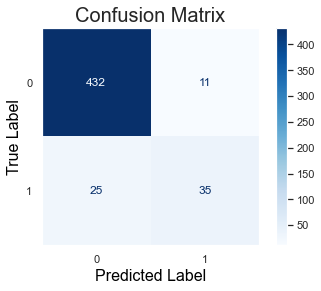

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       443
           1       0.76      0.58      0.66        60

    accuracy                           0.93       503
   macro avg       0.85      0.78      0.81       503
weighted avg       0.92      0.93      0.92       503

False Negative: 0.0497
False Positive: 0.0219


In [31]:
# With RFE
lr1 = LogisticRegression(random_state=rs)
# passing the lr through RFE
lr_rfe = RFE(lr1)
# Fitting the model
lr_rfe = lr_rfe.fit(pd.DataFrame(X_train1,columns=data_final_vars), pd.DataFrame(y_train1).values.ravel())
rfe_results = pd.DataFrame([data_final_vars,lr_rfe.support_,lr_rfe.ranking_],index=['Column','Support','Ranking']).T
# most important columns
rfe_columns = rfe_results[rfe_results['Support']==True]['Column'].values.tolist()

# Fitting using RFE Columns
lr1.fit(pd.DataFrame(X_train1,columns=data_final_vars)[rfe_columns],y_train1)
# Predicting the model using RFE
y_pred1 = lr1.predict(pd.DataFrame(X_test1,columns=data_final_vars)[rfe_columns])
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test1,y_pred1).round(3))
lr_y_score1 = lr1.decision_function(pd.DataFrame(X_test1,columns=data_final_vars)[rfe_columns])
print ("AUC Score is:",roc_auc_score(y_test1, lr_y_score1))

lr_cm1 = confusion_matrix(y_test1,y_pred1)


plot_confusion_matrix(lr_cm1,lr1.classes_,y_test1,y_pred1)
lr_fn_pct1,lr_fp_pct1 = false_negative_pct(pd.DataFrame(y_test1)[0],y_pred1)
dfm.loc['Logistic Regression - Scaled Data w/RFE'] =[accuracy_score(y_test1,y_pred1).round(3),roc_auc_score(y_test1, lr_y_score1),lr_fn_pct1]

In [32]:
# Coefficients of Features
lrc1 = pd.DataFrame([pd.DataFrame(X_test1,columns=data_final_vars).columns.values.tolist(),lr1.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc1.head(10)

,Feature,Coefficients
29,EducationField_Other,1.808463
15,BusinessTravel_Travel_Frequently,1.497966
8,TotalWorkingYears,1.256377
18,Department_Maternity,1.13372
34,EnvironmentSatisfaction_4,1.094623
30,EducationField_Technical Degree,0.970321
7,PercentSalaryHike,0.966044
31,EnvironmentSatisfaction_1,0.932685
25,EducationField_Human Resources,0.795918
23,Education_4,0.787485


In [33]:
dfm

,Accuracy,AUC,False Negative
Logistic Regression - Scaled Data,0.934,0.971840,0.0517
Logistic Regression - NonScaled Data,0.922,0.945135,0.0596
Logistic Regression - NonScaled Data w/RFE,0.903,0.908652,0.0755
Logistic Regression - Scaled Data w/RFE,0.928,0.966949,0.0497


#### Logistic Regression Analysis

Based on metrics, the model with the highest accuracy is Logistic Regression with Scaled Data and the model with the lowest false negative rate is Logistic Regression Scaled Data with RFE. Overall we want to limit the false negative error, which is where the model predicted no attrition, but there was attrition. We want to be able to catch when employees are about to leave, as we might want to stop them or plan for their departure.

Overall the scaled data yields better results, which makes sense, as outliers does raise issues. From here on out, we will only be using scaled data

<h3>Random Forest<a id = "rf" class="anchor"></a></h3>

Random Forest is an example of CARTs, and basically very many Decision Trees, with bagging and random sampling of features to create a forest of trees, where the prediction is done by committee.

Steps:

* Fit/Predict
* Crossvalidation
* Confusion Matrix
* AUC
* Feature Importances
* Analysis

In [34]:
param_grid = { 
    'n_estimators': [200, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

# rf = RandomForestClassifier(random_state=rs,n_jobs=-1)
# # Gridsearchcv
# cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
# cv_rf.fit(X_train1, y_train1)
# [(k,':',v) for k,v in cv_rf.best_params_.items()]

Logistic Regression Accuracy Score: 0.9005964214711729
AUC Score is: 0.9497178329571107
Average Cross Validation score :0.9110921015112632


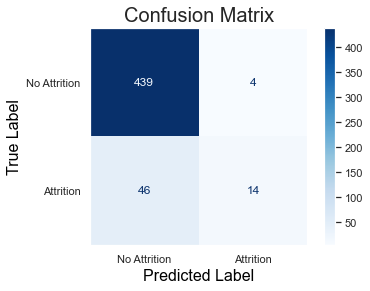

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       443
           1       0.78      0.23      0.36        60

    accuracy                           0.90       503
   macro avg       0.84      0.61      0.65       503
weighted avg       0.89      0.90      0.88       503

False Negative: 0.0915
False Positive: 0.008


In [35]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=rs,n_jobs=-1)
# Gridsearchcv
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
cv_rf.fit(X_train1, y_train1)
# selecting best parameters
rf = RandomForestClassifier(random_state=25,n_jobs=-1,
                            criterion=cv_rf.best_params_['criterion'],
                            max_depth=cv_rf.best_params_['max_depth'],
                            max_features=cv_rf.best_params_['max_features'],
                            n_estimators=cv_rf.best_params_['n_estimators'])
# Fitting the model
rf.fit(X_train1,y_train1)
# Predicting on the test set
rfy_pred = rf.predict(X_test1)
# Accuracy Score
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test1,rfy_pred))
# positive class for rf.predict_proba
print ("AUC Score is:",roc_auc_score(y_test1,rf.predict_proba(X_test1)[:,1] ))
# Confusion Matrix
rf_cm = confusion_matrix(y_test1,rfy_pred)

# Crossvalidation using Stratified K Fold - Explain why this is useful
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)
rfcvs = cross_val_score(rf,X_processed,y_processed.ravel(),cv=skf,n_jobs=-1)
print("Average Cross Validation score :{}".format(rfcvs.mean()))

# Plotting confusion matrix
plot_confusion_matrix(rf_cm,['No Attrition','Attrition'],y_test1,rfy_pred)
# False Negative/False Positive
rf_fn_pct,rf_fp_pct = false_negative_pct(pd.DataFrame(y_test1)[0],rfy_pred)

# Adding scores to model results dataframe
dfm.loc['Random Forest Classifier - Scaled Data'] =[accuracy_score(y_test1,rfy_pred).round(3),roc_auc_score(y_test1,rf.predict_proba(X_test1)[:,1] ),rf_fn_pct]

In [36]:
# Feature Importances - top 10 features in terms of importance
rf_fi = pd.DataFrame([data_final_vars,rf.feature_importances_.tolist()],index=['Feature','Feature Importance']).T
rf_fi.sort_values(by='Feature Importance',ascending=False).head(10)

,Feature,Feature Importance
0,Age,0.0762
4,MonthlyIncome,0.06685
8,TotalWorkingYears,0.063203
59,OverTime_1,0.062633
58,OverTime_0,0.058445
10,YearsAtCompany,0.044514
2,DistanceFromHome,0.036998
5,MonthlyRate,0.03319
13,YearsWithCurrManager,0.032841
1,DailyRate,0.032187


##### Random Forest with RFE

[('criterion', ':', 'entropy'), ('max_depth', ':', 7), ('max_features', ':', 'auto'), ('n_estimators', ':', 400)]
Random Forest Classifier Accuracy Score: 0.9065606361829026
AUC Score is: 0.543636104783599
Average Cross Validation score :0.9110921015112632


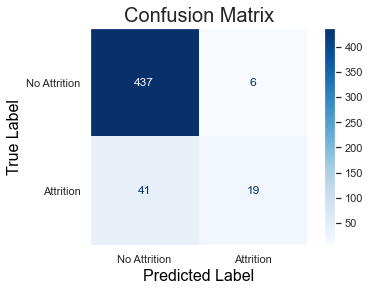

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       443
           1       0.76      0.32      0.45        60

    accuracy                           0.91       503
   macro avg       0.84      0.65      0.70       503
weighted avg       0.90      0.91      0.89       503

False Negative: 0.0815
False Positive: 0.0119


In [37]:
# Random Forest Classifier with RFE
rf1 = RandomForestClassifier(random_state=rs,n_jobs=-1)
# passing the rf1 through RFE
rf_rfe = RFE(rf1)
# Fitting the model
rf_rfe = rf_rfe.fit(X_train1, pd.DataFrame(y_train1).values.ravel())
rf_rfe_results = pd.DataFrame([data_final_vars,rf_rfe.support_,rf_rfe.ranking_],index=['Column','Support','Ranking']).T
# most important columns
rf_rfe_columns = rf_rfe_results[rf_rfe_results['Support']==True]['Column'].values.tolist()


# GridsearchCV
rf1 = RandomForestClassifier(random_state=rs,n_jobs=-1)
# Gridsearchcv
cv_rf1 = GridSearchCV(estimator=rf1, param_grid=param_grid, cv= 5)
cv_rf1.fit(pd.DataFrame(X_train1,columns=data_final_vars)[rf_rfe_columns], y_train1)
print([(k,':',v) for k,v in cv_rf1.best_params_.items()])

# selecting best parameters
rf1 = RandomForestClassifier(random_state=rs,n_jobs=-1,
                            criterion=cv_rf.best_params_['criterion'],
                            max_depth=cv_rf.best_params_['max_depth'],
                            max_features=cv_rf.best_params_['max_features'],
                            n_estimators=cv_rf.best_params_['n_estimators'])

# Fitting the model
rf1.fit(pd.DataFrame(X_train1,columns=data_final_vars)[rf_rfe_columns],y_train1)
# Predicting on the test set
rfy_pred1 = rf1.predict(pd.DataFrame(X_test1,columns=data_final_vars)[rf_rfe_columns])
# Accuracy Score
print ('Random Forest Classifier Accuracy Score:',accuracy_score(y_test1,rfy_pred1))
# positive class for rf.predict_proba
print ("AUC Score is:",roc_auc_score(y_test,rf1.predict_proba(pd.DataFrame(X_test1,columns=data_final_vars)[rf_rfe_columns])[:,1] ))
# Confusion Matrix
rf_cm1 = confusion_matrix(y_test1,rfy_pred1)

# Crossvalidation using Stratified K Fold - Explain why this is useful
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)
rfcvs = cross_val_score(rf1,X_processed,y_processed.ravel(),cv=skf,n_jobs=-1)
print("Average Cross Validation score :{}".format(rfcvs.mean()))


plot_confusion_matrix(rf_cm1,['No Attrition','Attrition'],y_test1,rfy_pred1.astype(int))
# False Negative/False Positive
rf_fn_pct,rf_fp_pct = false_negative_pct(pd.DataFrame(y_test1)[0],rfy_pred1)

# Adding scores to model results dataframe
dfm.loc['Random Forest Classifier - Scaled w/RFE'] =[accuracy_score(y_test1,rfy_pred1).round(3),roc_auc_score(y_test1,rf1.predict_proba(pd.DataFrame(X_test1,columns=data_final_vars)[rf_rfe_columns])[:,1] ),rf_fn_pct]

In [38]:
# Feature Importances - top 10 features in terms of importance
rf_fi = pd.DataFrame([rf_rfe_columns,rf1.feature_importances_.tolist()],index=['Feature','Feature Importance']).T
rf_fi.sort_values(by='Feature Importance',ascending=False).head(10)

,Feature,Feature Importance
0,Age,0.095895
4,MonthlyIncome,0.080556
8,TotalWorkingYears,0.072686
30,OverTime_1,0.069445
29,OverTime_0,0.057959
10,YearsAtCompany,0.049805
2,DistanceFromHome,0.046196
5,MonthlyRate,0.043364
1,DailyRate,0.041946
3,HourlyRate,0.038544


In [39]:
dfm

,Accuracy,AUC,False Negative
Logistic Regression - Scaled Data,0.934,0.971840,0.0517
Logistic Regression - NonScaled Data,0.922,0.945135,0.0596
Logistic Regression - NonScaled Data w/RFE,0.903,0.908652,0.0755
Logistic Regression - Scaled Data w/RFE,0.928,0.966949,0.0497
Random Forest Classifier - Scaled Data,0.901,0.949718,0.0915
Random Forest Classifier - Scaled w/RFE,0.907,0.949492,0.0815


#### Random Forest Analysis

* False Negative: 9.15%
* Accuracy: 90.1% 
* AUC: 95%


#### Random Forest w/RFE Analysis

* False Negative: 8.15%
* Accuracy: 90.7% 
* AUC: 95%

The numbers for random forest with and without RFE are very similar. Both did worse in terms of accuracy and false negative rate than Logistic Regression. #### Random Forest Analysis


<h3>Extra Trees<a id = "et" class="anchor"></a></h3>

Adding one further step of randomization (beyond Random Forest) yields ExtraTrees. These are trained using bagging just like random forest, but also an additional layer of randomness is introduced. Instead of computing the locally optimal feature/split combination (based on, e.g., information gain or the Gini impurity), for each feature under consideration, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.

This is to prevent overfitting, but always choosing the same splits/features

Steps:

* Fit/Predict
* Crossvalidation
* Confusion Matrix
* AUC
* Feature Importances
* Analysis

Logistic Regression Accuracy Score: 0.9065606361829026
AUC Score is: 0.9408013544018059
Average Cross Validation score :0.9122683205018534


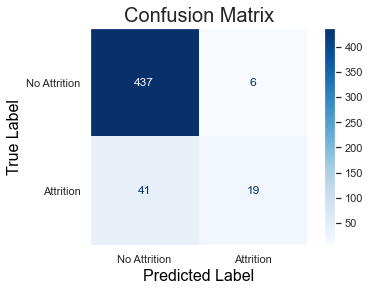

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       443
           1       0.76      0.32      0.45        60

    accuracy                           0.91       503
   macro avg       0.84      0.65      0.70       503
weighted avg       0.90      0.91      0.89       503

False Negative: 0.0815
False Positive: 0.0119


In [40]:
# ExtraTrees Classifier
et = ExtraTreesClassifier(random_state=rs,n_jobs=-1)
# Gridsearchcv
cv_et = GridSearchCV(estimator=et, param_grid=param_grid, cv= 5)
cv_et.fit(X_train1, y_train1)
# selecting best parameters
et = ExtraTreesClassifier(random_state=rs,n_jobs=-1,
                            criterion=cv_et.best_params_['criterion'],
                            max_depth=cv_et.best_params_['max_depth'],
                            max_features=cv_et.best_params_['max_features'],
                            n_estimators=cv_et.best_params_['n_estimators'])
# Fitting the model
et.fit(X_train1,y_train1)
# Predicting on the test set
ety_pred = et.predict(X_test1)
# Accuracy Score
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test1,ety_pred))
# positive class for rf.predict_proba
print ("AUC Score is:",roc_auc_score(y_test1,et.predict_proba(X_test1)[:,1] ))
# Confusion Matrix
et_cm = confusion_matrix(y_test1,ety_pred)

# Crossvalidation using Stratified K Fold - Explain why this is useful
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)
etcvs = cross_val_score(et,X_processed,y_processed.ravel(),cv=skf,n_jobs=-1)
print("Average Cross Validation score :{}".format(etcvs.mean()))

# Plotting confusion matrix
plot_confusion_matrix(et_cm,['No Attrition','Attrition'],y_test1,ety_pred)
# False Negative/False Positive
et_fn_pct,et_fp_pct = false_negative_pct(pd.DataFrame(y_test1)[0],ety_pred)

# Adding scores to model results dataframe
dfm.loc['Extra Trees Classifier - Scaled Data'] =[accuracy_score(y_test1,ety_pred).round(3),roc_auc_score(y_test1,et.predict_proba(X_test1)[:,1] ),et_fn_pct]

In [41]:
# Feature Importances - top 10 features in terms of importance
et_fi = pd.DataFrame([data_final_vars,et.feature_importances_.tolist()],index=['Feature','Feature Importance']).T
et_fi.sort_values(by='Feature Importance',ascending=False).head(10)

,Feature,Feature Importance
58,OverTime_0,0.099936
59,OverTime_1,0.090329
41,JobLevel_1,0.050194
66,Shift_0,0.036457
57,MaritalStatus_Single,0.032692
0,Age,0.030867
31,EnvironmentSatisfaction_1,0.027553
67,Shift_1,0.025259
8,TotalWorkingYears,0.023494
11,YearsInCurrentRole,0.023371


In [42]:
dfm

,Accuracy,AUC,False Negative
Logistic Regression - Scaled Data,0.934,0.971840,0.0517
Logistic Regression - NonScaled Data,0.922,0.945135,0.0596
Logistic Regression - NonScaled Data w/RFE,0.903,0.908652,0.0755
Logistic Regression - Scaled Data w/RFE,0.928,0.966949,0.0497
Random Forest Classifier - Scaled Data,0.901,0.949718,0.0915
Random Forest Classifier - Scaled w/RFE,0.907,0.949492,0.0815
Extra Trees Classifier - Scaled Data,0.907,0.940801,0.0815


<h3>Gradient Boosting<a id = "gbm" class="anchor"></a></h3>

* Explain Gradient Boosting

Steps:

* Fit/Predict
* Crossvalidation
* Confusion Matrix
* AUC
* Feature Importances
* Analysis

In [43]:
gb_parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_split": [10,100,200,500],
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": [50],
    "max_depth":[3,5,8],
   # "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.6,0.7, 0.8, 0.9, 1.0],
    "n_estimators":[100]
    }

Logistic Regression Accuracy Score: 0.9224652087475149
AUC Score is: 0.9542325056433408
Average Cross Validation score :0.9367408041060736


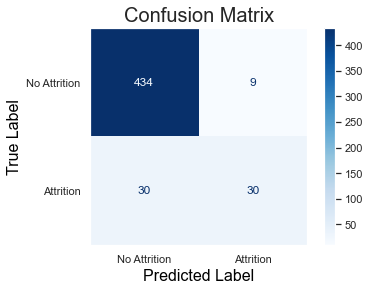

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       443
           1       0.77      0.50      0.61        60

    accuracy                           0.92       503
   macro avg       0.85      0.74      0.78       503
weighted avg       0.92      0.92      0.92       503

False Negative: 0.0596
False Positive: 0.0179


In [46]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=25)
# Gridsearchcv
cv_gb = GridSearchCV(estimator=gb, param_grid=gb_parameters, cv= 5)
cv_gb.fit(X_train1, y_train1)
#cv_gb.best_estimator_,cv_gb.best_params_, cv_gb.best_score_
# selecting best parameters
gb = GradientBoostingClassifier(random_state=25,
                            loss=cv_gb.best_params_['loss'],
                            learning_rate=cv_gb.best_params_['learning_rate'],
                            #min_samples_split=cv_gb.best_params_['min_samples_split'],
                            min_samples_leaf=cv_gb.best_params_['min_samples_leaf'],
                            max_depth=cv_gb.best_params_['max_depth'],
                            #max_features=cv_gb.best_params_['max_features'],
                            criterion=cv_gb.best_params_['criterion'],
                            subsample=cv_gb.best_params_['subsample'],
                            n_estimators=cv_gb.best_params_['n_estimators'])
# Fitting the model
gb.fit(X_train1,y_train1)
# Predicting on the test set
gby_pred = gb.predict(X_test1)
# Accuracy Score
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test1,gby_pred))
# positive class for rf.predict_proba
print ("AUC Score is:",roc_auc_score(y_test1,gb.predict_proba(X_test1)[:,1] ))
# Confusion Matrix
gb_cm = confusion_matrix(y_test1,gby_pred)

# Crossvalidation using Stratified K Fold - Explain why this is useful
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)
gbcvs = cross_val_score(gb,X_processed,y_processed.ravel(),cv=skf,n_jobs=-1)
print("Average Cross Validation score :{}".format(gbcvs.mean()))

# Plotting confusion matrix
plot_confusion_matrix(gb_cm,['No Attrition','Attrition'],y_test1,gby_pred)
# False Negative/False Positive
gb_fn_pct,gb_fp_pct = false_negative_pct(pd.DataFrame(y_test1)[0],gby_pred)

# Adding scores to model results dataframe
dfm.loc['Gradient Boosting Classifier - Scaled Data'] =[accuracy_score(y_test1,gby_pred).round(3),roc_auc_score(y_test1,gb.predict_proba(X_test1)[:,1] ),gb_fn_pct]

In [47]:
# Feature Importances - top 10 features in terms of importance
gb_fi = pd.DataFrame([data_final_vars,gb.feature_importances_.tolist()],index=['Feature','Feature Importance']).T
gb_fi.sort_values(by='Feature Importance',ascending=False).head(10)

,Feature,Feature Importance
59,OverTime_1,0.145445
0,Age,0.131901
4,MonthlyIncome,0.095655
10,YearsAtCompany,0.054989
8,TotalWorkingYears,0.051639
31,EnvironmentSatisfaction_1,0.048649
2,DistanceFromHome,0.048614
66,Shift_0,0.045922
13,YearsWithCurrManager,0.042249
6,NumCompaniesWorked,0.035833


In [48]:
dfm

,Accuracy,AUC,False Negative
Logistic Regression - Scaled Data,0.934,0.971840,0.0517
Logistic Regression - NonScaled Data,0.922,0.945135,0.0596
Logistic Regression - NonScaled Data w/RFE,0.903,0.908652,0.0755
Logistic Regression - Scaled Data w/RFE,0.928,0.966949,0.0497
Random Forest Classifier - Scaled Data,0.901,0.949718,0.0915
Random Forest Classifier - Scaled w/RFE,0.907,0.949492,0.0815
Extra Trees Classifier - Scaled Data,0.907,0.940801,0.0815
Gradient Boosting Classifier - Scaled Data,0.922,0.954233,0.0596


<h3>Conclusion<a id = "conclusion" class="anchor"></a></h3>

The analysis of attrition in healthcare used the following models to predict attrition:

* Logistic Regression
* Random Forest
* Extra Trees
* Gradient Boosting
* 

After evaluating the above models, the best model is Logistic Regression usign Scaled Data/RFE. Though this might be due to overfitting. Gradient Boosting performed te same as Logistic Regression not using scaled data. Disregarding Logistic Regression, Gradient Boosting performed the best in terms of accuracy and false negatives.

There seems to be overfitting issues and a class imbalance issue. Future enhancements should tackle these issues
#### Potential Implications

* Overfitting
* Class Imbalance

#### Enhancements

* Techniques to reduce overfitting
* Techniques to deal with Class Imbalance
* Enhance Hyperparameter tuning

